In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/glove-6b-100-d/glove.6B.100d.txt


In [2]:
import pandas as pd

In [3]:
dataset=pd.read_csv(r"/kaggle/input/amazon-fine-food-reviews/Reviews.csv")

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
dataset.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
print(dataset[['Score','Text']].head(5))

   Score                                               Text
0      5  I have bought several of the Vitality canned d...
1      1  Product arrived labeled as Jumbo Salted Peanut...
2      4  This is a confection that has been around a fe...
3      2  If you are looking for the secret ingredient i...
4      5  Great taffy at a great price.  There was a wid...


In [7]:
print(dataset.isna().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [8]:
lmtpData=dataset[['Text','Summary','Score']].sample(n=1000)
print(lmtpData)

                                                     Text  \
524901  What a find.  For those persons who need no (o...   
18666   My dogs love these! It's a great treat to give...   
337754  The quality was very good, but I ordered 2 pac...   
366415  These soft treats are great for old dogs who h...   
45936   I love ginger and enjoy the flavor in a variet...   
...                                                   ...   
455140  Chipotle has made a great impact in such a sho...   
74793   I have a 10 month old puppy. She is a mix betw...   
424558  Purchased two boxes in the past. Latest order ...   
191716  I bought a 3 bag pack, all 3 bags were sour ta...   
234746  I was initially surprised how big the toy was ...   

                                                  Summary  Score  
524901                 Great Tasting, heart healthy chips      5  
18666                                               Zukes      5  
337754                                      Not odor free      1  

### ADDING SENTIMENT COLUMN

In [9]:
#0-negative, 1-positive
def lblScore(score):
    if score<=2:
        return 0
    elif score>=4:
        return 1
    else:
        return 2
lmtpData['Sentiment']=lmtpData['Score'].apply(lblScore)
lmtpData.head(5)

,Text,Summary,Score,Sentiment
524901,What a find. For those persons who need no (o...,"Great Tasting, heart healthy chips",5,1
18666,My dogs love these! It's a great treat to give...,Zukes,5,1
337754,"The quality was very good, but I ordered 2 pac...",Not odor free,1,0
366415,These soft treats are great for old dogs who h...,Blue Dog Bakery rocks again!,5,1
45936,I love ginger and enjoy the flavor in a variet...,I like it,4,1


In [10]:
lmtpData['Sentiment'].value_counts()

Sentiment
1    772
0    161
2     67
Name: count, dtype: int64

#### VECTORS

In [11]:
import numpy as np

glove_path = "/kaggle/input/glove-6b-100-d/glove.6B.100d.txt"

def loadGloveEmbeddings(filePath, embedding_dim=100):
    embeddingsIndex = {}
    with open(filePath, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = coefs
    return embeddingsIndex

gloveEmbeddings = loadGloveEmbeddings(glove_path)
print("Loaded {} word vectors.".format(len(gloveEmbeddings)))


        

Loaded 400000 word vectors.


#### CREATING EMBEDDING MATRIX

In [12]:
lmtpData['Summary']=lmtpData['Summary'].fillna("")
lmtpData['CombinedText']=lmtpData['Summary'] + " " + lmtpData['Text']


In [13]:
#tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer()
tokenizer.fit_on_texts(lmtpData['CombinedText'])
sequences=tokenizer.texts_to_sequences(lmtpData['CombinedText'])

maxLen=100
padded_sequences=pad_sequences(sequences,maxlen=maxLen,padding='post')

In [14]:
embedding_dim=100
vocabSize=len(tokenizer.word_index) + 1

embeddingMatrix=np.zeros((vocabSize,embedding_dim))

for word,i in tokenizer.word_index.items():
    embeddingVector=gloveEmbeddings.get(word)
    if embeddingVector is not None:
        embeddingMatrix[i]=embeddingVector

In [15]:
print("Embedding matrix shape:", embeddingMatrix.shape)


Embedding matrix shape: (7121, 100)


### MAKING THE MODEL

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Input
maxLen=100
X_train = padded_sequences 
y_train = lmtpData["Sentiment"].values  

print("Padded shape:", X_train.shape)  
print("Labels shape:", y_train.shape) 

model = Sequential([
    Input(shape=(maxLen,)),
    Embedding(input_dim=vocabSize,  
              output_dim=embedding_dim, 
              weights=embeddingMatrix, 
             
              trainable=False), 
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.3),
    Dense(3, activation='softmax') 
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Padded shape: (1000, 100)
Labels shape: (1000,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │         712,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 878,951 (3.35 MB)

 Trainable params: 166,851 (651.76 KB)

 Non-trainable params: 712,100 (2.72 MB)

In [17]:

history=model.fit(padded_sequences, y_train, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.7445 - loss: 0.9362 - val_accuracy: 0.8000 - val_loss: 0.6224
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.7517 - loss: 0.7545 - val_accuracy: 0.8000 - val_loss: 0.6189
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.7664 - loss: 0.6949 - val_accuracy: 0.8000 - val_loss: 0.6162
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.7733 - loss: 0.6644 - val_accuracy: 0.8000 - val_loss: 0.6198
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.7749 - loss: 0.6763 - val_accuracy: 0.8000 - val_loss: 0.6289
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.7676 - loss: 0.6725 - val_accuracy: 0.8000 - val_loss: 0.6176
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.7758 - loss: 0.6703 - val_accuracy: 0.8000 - val_loss: 0.6142
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.7507 - loss: 0.6786 - val_accuracy: 0.

#### PLOTTING AND ACCURACY AND LOSS CURVES

In [18]:
import matplotlib.pyplot as plt
accuracy=history.history['accuracy']
valAccuracy=history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']
epochs_range = range(1, len(accuracy) + 1)

Text(0.5, 1.0, 'Training & Validation Accuracy')

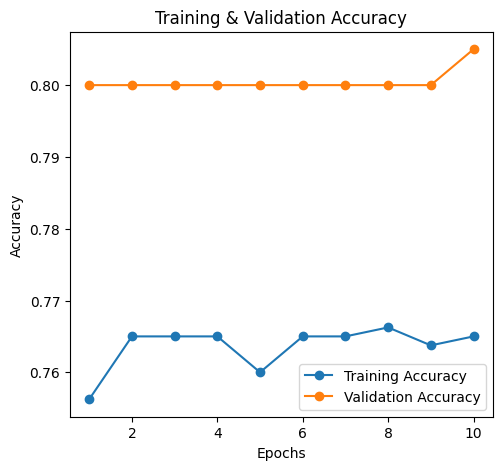

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs_range, valAccuracy, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')

Text(0.5, 1.0, 'Training & Validation Loss')

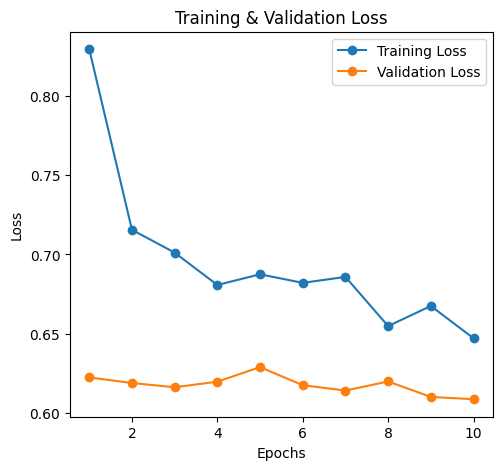

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, valLoss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')

##### overfitting

## TRAINING USING NEW SAMPLE DATASET

In [21]:
droppedData=dataset.drop(lmtpData.index)
dataset2=droppedData.sample(1000,random_state=43)
dataset2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150187,150188,B001AJDO3U,A3QWT88NZ24J6B,Gil Good,1,1,5,1299628800,Tomato powder,Excellent value. This product is not availabl...
541138,541139,B000FMTJJQ,A3EXVBHZKKCER,M. T. White,0,0,5,1193788800,Good stuff,"Great stuff to replace sugar. Just a light, s..."
480355,480356,B000DZDJ0K,AU4SGJS71ZV55,Charlotta HIbbs,0,0,5,1304380800,Great waffles...,This gluten-free flour mix is great for waffle...
363028,363029,B0049WV8S8,A1ICSLT0QFFC1D,"Ralph E. Bixler ""Ralph B""",1,1,2,1347494400,warning,"This item will cook your bacon, but it is not ..."
555890,555891,B001TLY7BM,A13Q9TG853K1J6,"P. ONeill ""RighteousDude""",0,0,5,1349654400,Very Satisfied,Very satisfied. Case arrived in 3 days and it ...


In [22]:
lmtpData2=dataset2[['Score','Summary','Text']]
lmtpData2.head()

,Score,Summary,Text
150187,5,Tomato powder,Excellent value. This product is not availabl...
541138,5,Good stuff,"Great stuff to replace sugar. Just a light, s..."
480355,5,Great waffles...,This gluten-free flour mix is great for waffle...
363028,2,warning,"This item will cook your bacon, but it is not ..."
555890,5,Very Satisfied,Very satisfied. Case arrived in 3 days and it ...
